In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Sentiment analysis/final_data_with_sentiment (1).csv')

In [ ]:
df

,category,comment
0,0,last session day
1,1,Shanghai also really exciting precisely skyscr...
2,-1,secession hit Veronique Branquinho quit compan...
3,1,happy day
4,1,I like
...,...,...
30877,-1,wish could come see you Denver husband lose jo...
30878,-1,ve wonder rake the client make clear NET do no...
30879,1,may good Enjoy break probably need hectic week...
30880,1,but worth


In [ ]:
df.rename(columns = {'comment':'Text','category':'sentiments'}, inplace = True)

In [ ]:
# Preprocess text
df['Text'] = df['Text'].astype(str).apply(lambda x: x.lower())
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.sentiments.values)

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # This line is added to import the necessary class

#Import the pickle module
import pickle # Importing the pickle module to enable object serialization

# Train TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['Text'])
X_test_tfidf = vectorizer.transform(test_df['Text'])

# Save vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
print("vectorizer.pkl saved successfully!")

vectorizer.pkl saved successfully!


In [ ]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

In [ ]:
MAX_LEN = 167
BATCH_SIZE = 64
hidden_dim = 64
output_size = 3


if torch.cuda.is_available():

       device = torch.device("cuda")

else:
       device = torch.device("cpu")


print(f'Current device is {device}')

Current device is cpu


In [ ]:
class Dataset:
    def __init__(self, text, sentiment):
        self.text = text
        # Remap sentiment labels to 0, 1, 2
        self.sentiment = [s + 1 for s in sentiment]

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = self.text[item, :]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])

    return data

In [ ]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]

    return embedding_matrix

In [ ]:
df['Text'] = df['Text'].astype(str).apply(lambda x: x.lower() if isinstance(x, str) else str(x))
train_df['Text'] = train_df['Text'].astype(str).apply(lambda x: x.lower() if isinstance(x, str) else str(x))
test_df['Text'] = test_df['Text'].astype(str).apply(lambda x: x.lower() if isinstance(x, str) else str(x))

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)

In [ ]:
df

,sentiments,Text
0,0,last session day
1,1,shanghai also really exciting precisely skyscr...
2,-1,secession hit veronique branquinho quit compan...
3,1,happy day
4,1,i like
...,...,...
30877,-1,wish could come see you denver husband lose jo...
30878,-1,ve wonder rake the client make clear net do no...
30879,1,may good enjoy break probably need hectic week...
30880,1,but worth


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
# schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[6] ,
#                                                         gamma=0.055)

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

Current device: cpu
Epoch 1/2:
  Train Loss: 1.0877, Train Acc: 40.35%
  Valid Loss: 1.0878, Valid Acc: 40.44%
Epoch 2/2:
  Train Loss: 1.0872, Train Acc: 40.43%
  Valid Loss: 1.0870, Valid Acc: 40.44%


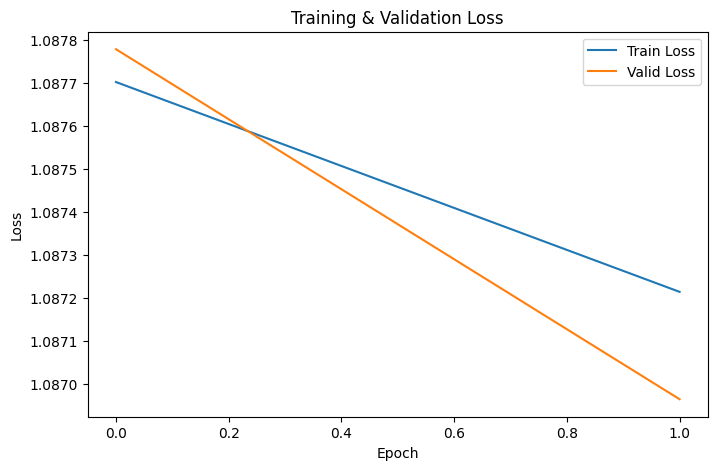

In [ ]:


# Convert text to lowercase.
df['Text'] = df['Text'].astype(str).apply(lambda x: x.lower())

# Stratified split on sentiments.
y = df.sentiments.values
train_df, test_df = train_test_split(df, test_size=0.2, stratify=y, random_state=42)

# Hyperparameters for sequences.
MAX_LEN = 167
BATCH_SIZE = 32
embedding_dim = 300   # Desired embedding dimension.
hidden_dim = 64
output_size = 3       # Number of sentiment classes.

# Create and fit the Keras tokenizer.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

# Convert texts to sequences.
xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)

# Pad sequences to MAX_LEN.
xtrain = pad_sequences(xtrain, maxlen=MAX_LEN, padding='post', truncating='post')
xtest = pad_sequences(xtest, maxlen=MAX_LEN, padding='post', truncating='post')

# Vocabulary size (add 1 for the unknown token).
vocab_size = len(tokenizer.word_index) + 1

# ===============================
# 2. Define Custom Dataset
# ===============================
class SentimentDataset(Dataset):
    def __init__(self, texts, sentiments):
        self.texts = texts
        # Remap sentiment labels: if they are -1, 0, 1 then adding 1 makes them 0,1,2.
        self.sentiments = np.array(sentiments) + 1

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        sentiment = self.sentiments[idx]
        return {
            'text': torch.tensor(text, dtype=torch.long),
            'target': torch.tensor(sentiment, dtype=torch.long)
        }

# Create Dataset objects and DataLoaders.
train_dataset = SentimentDataset(xtrain, train_df.sentiments.values)
valid_dataset = SentimentDataset(xtest, test_df.sentiments.values)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# 3. Define the Model (Trainable Embedding)
# ===============================
class sentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        """
        A Bidirectional LSTM for sentiment analysis using a trainable embedding layer.
        Parameters:
          vocab_size: Size of vocabulary.
          embedding_dim: Dimension of word embeddings (e.g., 300).
          hidden_dim: LSTM hidden state dimension.
          output_size: Number of output classes (e.g., 3).
        """
        super(sentimentBiLSTM, self).__init__()
        # Create trainable embedding layer (randomly initialized).
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        # Define a bidirectional LSTM.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Fully connected layer. (Hidden dimension is doubled due to bidirectionality.)
        self.fc = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length]
        embeds = self.embedding(x)             # [batch_size, seq_length, embedding_dim]
        lstm_out, _ = self.lstm(embeds)          # [batch_size, seq_length, hidden_dim*2]
        # Use the last time-step's output.
        lstm_last = lstm_out[:, -1, :]           # [batch_size, hidden_dim*2]
        logits = self.fc(lstm_last)              # [batch_size, output_size]
        return F.softmax(logits, dim=1)

# ===============================
# 4. Set Up Training
# ===============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

model = sentimentBiLSTM(vocab_size, embedding_dim, hidden_dim, output_size)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def accuracy(output, labels):
    preds = output.argmax(dim=1)
    return (preds == labels).float().sum().item()

# ===============================
# 5. Training Loop
# ===============================
epochs = 2
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch in train_loader:
        inputs = batch['text'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc += accuracy(outputs, targets)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_acc / len(train_dataset)

    model.eval()
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch['text'].to(device)
            targets = batch['target'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_running_loss += loss.item() * inputs.size(0)
            valid_running_acc += accuracy(outputs, targets)

    valid_loss = valid_running_loss / len(valid_dataset)
    valid_acc = valid_running_acc / len(valid_dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%')
    print(f'  Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc*100:.2f}%')

# ===============================
# 6. Save the Trained Model and Tokenizer (optional)
# ===============================
torch.save(model.state_dict(), 'model.pkl')
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# ===============================
# 7. Plot Training Curves (optional)
# ===============================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()
